In [13]:
import pickle
import numpy as np
from sklearn.utils import shuffle

d = pickle.load(open('train_data.p', 'rb'))
train_x = np.array(d['train_x'], dtype=np.float32)
train_y = np.array(d['train_y'])

train_y[train_y == -1] = 0

train_x, train_y = shuffle(train_x, train_y)
train_x = train_x - 128
train_x = train_x / 128

print('Loaded.')

Loaded.


In [14]:
print(train_x.shape, train_y.shape)

(25000, 32, 32, 3) (25000,)


0 0 1 1
0.992188 -1.0


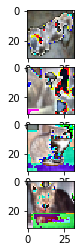

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

print(train_y[500], train_y[501], train_y[502], train_y[503])
print (np.max(train_x), np.min(train_x))

plt.subplot(411)
plt.imshow(train_x[500])
plt.subplot(412)
plt.imshow(train_x[501])
plt.subplot(413)
plt.imshow(train_x[502])
plt.subplot(414)
plt.imshow(train_x[503])



In [16]:
import tensorflow as tf
def model(x):
    w_l1 = tf.Variable(tf.random_normal([4,4,3,20]))
    b_l1 = tf.Variable(tf.random_normal([20]))
    conv1 = tf.nn.conv2d(x, w_l1, [1,1,1,1], 'VALID') + b_l1
    relu1 = tf.nn.relu(conv1)
    maxpool1 = tf.nn.max_pool(relu1, [1,2,2,1], [1,2,2,1], 'VALID')
    
    w_l2 = tf.Variable(tf.random_normal([4,4,20,40]))
    b_l2 = tf.Variable(tf.random_normal([40]))
    conv2 = tf.nn.conv2d(maxpool1, w_l2, [1,1,1,1], 'VALID') + b_l2
    relu2 = tf.nn.relu(conv2)
    maxpool2 = tf.nn.max_pool(relu2, [1,2,2,1], [1,2,2,1], 'VALID')    
    flat = tf.contrib.layers.flatten(maxpool2)

    f1_w = tf.Variable(tf.random_normal([1000, 100]))
    f1_b = tf.Variable(tf.random_normal([100]))
    full1 = tf.add(tf.matmul(flat, f1_w), f1_b)
    
    f2_w = tf.Variable(tf.random_normal([100, 2]))
    f2_b = tf.Variable(tf.random_normal([2]))
    full2 = tf.add(tf.matmul(full1, f2_w), f2_b)
    
    return full2
                       

print(model(train_x[1].reshape((1,32,32,3))))
    

Tensor("Add_7:0", shape=(1, 2), dtype=float32)


In [17]:

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

rate = 0.001
one_hot_y = tf.one_hot(y, 2)
logits = model(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate, name="optimizer").minimize(cost)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

pred = tf.argmax(tf.nn.softmax(logits),1)
#print(logits.shape, pred.shape)

In [29]:
nt = 10000
val_start = 16000
val_end = 16300

xt = train_x[0:nt]
yt = train_y[0:nt]

xv = train_x[val_start:val_end]
yv = train_y[val_start:val_end]


print (xt.shape, yt.shape, xv.shape, yv.shape)

(10000, 32, 32, 3) (10000,) (300, 32, 32, 3) (300,)


In [30]:
batch_size = 100
batch_n = int(len(xt)/batch_size)
epochs = 3
init = tf.global_variables_initializer()

ab = []
at = []
av = []

with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        for b in range(batch_n):
            x_batch, y_batch = xt[b:(b+1) * batch_size], yt[b:(b+1) * batch_size]
            sess.run(optimizer, feed_dict={x: x_batch, y: y_batch})
            lost = sess.run(cost, feed_dict={x: x_batch, y: y_batch})
            acc_b = sess.run(accuracy, feed_dict={x: x_batch, y: y_batch})
            acc_ft = sess.run(accuracy, feed_dict={x: xt, y: yt})
            acc_val = sess.run(accuracy, feed_dict={x: xv, y:yv})
            
            ab.append(acc_b)
            at.append(acc_ft)
            av.append(acc_val)
            print ("e: {}, b: {}/{}, lost : {}, acc: {}, {}, acc_val: {}".format(e, b, batch_n, lost, acc_b, acc_ft, acc_val))

        
        
    """for u in range(nt):
        pr = sess.run(pred, feed_dict={x: xt[u].reshape((1,32,32,3))})
        print(yt[u], pr)"""
  
    print("done.")
    
plt.plot(ab)
plt.plot(at)
plt.plot(av)
plt.show()

e: 0, b: 0/100, lost : 18866.115234375, acc: 0.45000001788139343, 0.49779990315437317, acc_val: 0.550000011920929
e: 0, b: 1/100, lost : 15806.6015625, acc: 0.47236180305480957, 0.49669986963272095, acc_val: 0.5499999523162842
e: 0, b: 2/100, lost : 13606.984375, acc: 0.4563758671283722, 0.49439987540245056, acc_val: 0.5466666221618652
e: 0, b: 3/100, lost : 10438.388671875, acc: 0.4685138463973999, 0.4927998483181, acc_val: 0.5499999523162842
e: 0, b: 4/100, lost : 7898.6455078125, acc: 0.4697580635547638, 0.4923999011516571, acc_val: 0.5433332920074463
e: 0, b: 5/100, lost : 6017.87939453125, acc: 0.48235297203063965, 0.489999920129776, acc_val: 0.5533333420753479
e: 0, b: 6/100, lost : 4785.94580078125, acc: 0.47694525122642517, 0.4843998849391937, acc_val: 0.49666666984558105
e: 0, b: 7/100, lost : 4596.90771484375, acc: 0.498108446598053, 0.48359984159469604, acc_val: 0.46666666865348816
e: 0, b: 8/100, lost : 4815.13525390625, acc: 0.49775785207748413, 0.48629987239837646, acc_va

ResourceExhaustedError: OOM when allocating tensor with shape[9802,20,14,14]
	 [[Node: gradients_2/MaxPool_8_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](Relu_8, MaxPool_8, gradients_2/Conv2D_9_grad/tuple/control_dependency)]]

Caused by op 'gradients_2/MaxPool_8_grad/MaxPoolGrad', defined at:
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-e8d4ea649ede>", line 11, in <module>
    optimizer = tf.train.AdamOptimizer(learning_rate = rate, name="optimizer").minimize(cost)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 269, in minimize
    grad_loss=grad_loss)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/training/optimizer.py", line 335, in compute_gradients
    colocate_gradients_with_ops=colocate_gradients_with_ops)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py", line 482, in gradients
    in_grads = grad_fn(op, *out_grads)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/nn_grad.py", line 404, in _MaxPoolGrad
    data_format=op.get_attr("data_format"))
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1697, in _max_pool_grad
    data_format=data_format, name=name)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

...which was originally created as op 'MaxPool_8', defined at:
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
[elided 18 identical lines from previous traceback]
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-17-e8d4ea649ede>", line 7, in <module>
    logits = model(x)
  File "<ipython-input-16-17d059af004a>", line 7, in model
    maxpool1 = tf.nn.max_pool(relu1, [1,2,2,1], [1,2,2,1], 'VALID')
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/nn_ops.py", line 1617, in max_pool
    name=name)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/ops/gen_nn_ops.py", line 1598, in _max_pool
    data_format=data_format, name=name)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[9802,20,14,14]
	 [[Node: gradients_2/MaxPool_8_grad/MaxPoolGrad = MaxPoolGrad[T=DT_FLOAT, data_format="NHWC", ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1], _device="/job:localhost/replica:0/task:0/gpu:0"](Relu_8, MaxPool_8, gradients_2/Conv2D_9_grad/tuple/control_dependency)]]
